Trying neg() correction w/o neg samples

In [ ]:
version = "v16a"

In [ ]:
################ For subsampling ################
# Remove words (tokens) for frequent occurances?
enable_subsampling = True
# Lower threshold -> More removal
subsample_threshold = 1e-5


# Remove words (types) with low context representation?
remove_low_context = False
# Higher threshold -> More removal
low_context_threshold = 100

################ Model parameters ################
# Size of embeddings
embedding_dim = 300
# -1 for dynamic on context size, pick minimum 2
win_size = 4
# Number of neg samples per one context word
neg_samp = 5


################ Training parameters ################
# Size ratio val/total
val_partition = 0.1

# Higher -> Faster, Lower -> More generalization
batch_size = 128
# Batch for val loss calculation
validation_batch_size = 1024

# Length of training
epochs = 3

# Step size in learning
learning_rate = 0.003
# 1.0 -> No decay, (0 , 1.0) -> LR drops in process
lr_decay_rate = 1.0
# Update LR per how many epochs
lr_decay_step = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/3rd-order-softplus
!ls

Mounted at /content/drive
/content/drive/MyDrive/Experiments/3rd-order-softplus
data  models  standards  voca


In [ ]:
import copy
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import re
import time
import torch
from collections import Counter
from prettytable import PrettyTable
from scipy.stats import spearmanr
from statistics import mean
from torch import nn
import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on '%s'." % (device))

Running on 'cuda'.


In [ ]:
try:
  os.makedirs('voca/' + version)
  print("'voca/" + version + "' created.")
except OSError as error:
  print("'voca/" + version + "' already exists.")

try:
  os.makedirs('models/' + version)
  print("'models/" + version + "' created.")
except OSError as error:
  print("'models/" + version + "' already exists.")


'voca/v16a' created.
'models/v16a' created.


In [ ]:
to_path = lambda s1, s2, s3: s1 + "/" + s2 + "/" + s3
to_tensor = lambda v: torch.LongTensor(v).to(device)

# Prepare Vocab

In [ ]:
def preprocess(text):

  # lowercase
  text = text.lower()

  # separate these punctuation marks from the words in the text and allow the model to treat them differently.
  text = text.replace('.', ' <PERIOD> ')
  text = text.replace(',', ' <COMMA> ')
  text = text.replace('"', ' <QUOTATION_MARK> ')
  text = text.replace(';', ' <SEMICOLON> ')
  text = text.replace('!', ' <EXCLAMATION_MARK> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('(', ' <LEFT_PAREN> ')
  text = text.replace(')', ' <RIGHT_PAREN> ')
  text = text.replace('--', ' <HYPHENS> ')
  text = text.replace('?', ' <QUESTION_MARK> ')
  text = text.replace('\n', ' <NEW_LINE> ')
  text = text.replace(':', ' <COLON> ')

  # splits the text into individual words
  words = text.split()

  # remove words with five or fewer occurrences. reduce the size of the vocabulary and improve the efficiency of the model.
  word_counts = Counter(words)  # dictionary word:occurrences
  trimmed_words = [word for word in words if word_counts[word] > 5] # Remove any word fewer than 5 tokens

  # remove common words that do not provide much meaning to the text
  stop = [
  "a", "about", "above", "after", "again", "against", "all", "also", "altough", "am", "an", "and", "any", "are", "aren't", "as", "at",
  "b", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by",
  "c", "can", "can't", "cannot", "could", "couldn't",
  "d", "de", "did", "didn't", "do", "does", "doesn't", "doing", "don't", "down", "during",
  "e", "each", "either", "even",
  "f", "few", "for", "from", "further",
  "g",
  "h", "had", "hadn't", "has", "hasn't", "have", "haven't", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's",
  "hers", "herself", "him", "himself", "his", "how", "how's", "however",
  "i", "i'd", "i'll", "i'm", "i've", "if", "ii", "in", "into", "is", "isn't", "it", "it's", "its", "itself",
  "j", "just",
  "k",
  "l", "like",
  "m", "many", "may", "me", "more", "most", "much", "must", "my", "myself",
  "n", "nd", "neither", "no", "nor", "not", "now",
  "o", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own",
  "p",
  "q",
  "r", "rd",
  "s", "same", "shall", "she", "she'd", "she'll", "she's", "should", "shouldn't", "so", "some", "such",
  "t", "th", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they",
  "they'd", "they'll", "they're", "they've", "this", "those", "though", "through", "to", "too",
  "u", "under", "until", "up", "us",
  "v", "very",
  "w", "was", "wasn't", "we", "we'd", "we'll", "we're", "we've", "were", "weren't", "what", "what's", "when", "when's", "where",
  "where's", "which", "while", "who", "who's", "whom", "why", "why's", "will", "with", "won't", "would", "wouldn't",
  "x",
  "y", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves",
  "z",
  "zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"
  ]

  stop_trimmed_words = [w for w in trimmed_words if w not in stop]

  return stop_trimmed_words

In [ ]:
with open('data/text8') as f:
    text = f.read()

words = preprocess(text)

print("Total words in text: %d" % (len(words)))
print("Unique words in text: %d" % (len(set(words))))

Total words in text: 8448361
Unique words in text: 63459


In [ ]:
def create_lookup_tables(words):

  word_counts = Counter(words)  # dictionary "word:number of occurrences"

  count = []  # list of tuples (word, number of occurrences) from most frequent, e.g. [('one', 411764),...]
  count.extend(Counter(words).most_common(len(words)))

  sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # list of words sorted in decreasing frequency
  # order of a word in this list becomes its index

  int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}  # dictionary index:word {0: 'one',...}
  vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}  # dictionary word:index {'one': 0,...}

  return vocab_to_int, int_to_vocab, count

In [ ]:
vocab_to_int, int_to_vocab, count = create_lookup_tables(words)

In [ ]:
def prepare_train_words(words, enable_subsampling, subsample_threshold):

  train_words = []

  if enable_subsampling:

    int_words = [vocab_to_int[word] for word in words]
    word_counts = Counter(int_words)

    freqs = {word: count / len(int_words) for word, count in word_counts.items()} # dict word_idx:rel_freq
    p_drop = {word: 1 - np.sqrt(subsample_threshold / freqs[word]) for word in word_counts} # dict word_idx:prob_dropping

    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])] # list of words after subsampling

  else:

    train_words = [vocab_to_int[word] for word in words]

  return train_words

In [ ]:
train_words = prepare_train_words(words, enable_subsampling, subsample_threshold)

print("Total words for training: {}".format(len(train_words)))
print("Unique words for training: {}".format(len(set(train_words))))

Total words for training: 3427273
Unique words for training: 63459


# Save vocab to file

In [ ]:
def save_vocab(count, vocab_words):
  with open(to_path("voca", version, "voca.txt"), "w") as f:
    for i in range(len(count)):
      vocab_word = vocab_words[i]
      f.write("%s %d\n" % (vocab_word, count[i][1]))

In [ ]:
save_vocab(count, int_to_vocab)

# Sampling

In [ ]:
# Create a sampling table for neg sampling, each element appears number of times relative to its frequency.

def init_sample_table(count):
  count = [ele[1] for ele in count] # List of number of occurances, sorted; [occ1, occ2, occ3...]

  pow_frequency = np.array(count) ** 0.75 # Power occurances by .75
  power = sum(pow_frequency) # for normalization
  ratio = pow_frequency / power # relative power frequencies list

  table_size = 1e8
  sampling_count = np.round(ratio * table_size) # how many times an element should be added to the sampling table

  sample_table = []
  for idx, x in enumerate(sampling_count):
    sample_table += [idx] * int(x) # add each word's idx to the table, number of times specificed in sampling_count

  return np.array(sample_table)

In [ ]:
sample_table = init_sample_table(count)

In [ ]:
def get_context(words, idx, win_size, idx_to_contexts):

  if win_size < 0:
    ctx_count = len(idx_to_contexts[words[idx]])
    R = ( 3 - min( int( ctx_count / 150 ) , 2 ) ) * 2
  else:
    R = np.random.randint(2, max(win_size+1, 3))

  start = idx - R if (idx - R) > 0 else 0
  stop = idx + R
  context_words = words[start : idx] + words[idx + 1 : stop + 1]

  return list(set(context_words))

for an index i,
* $central\_words[i]$ -> a target word
* $context\_words1[i]$ and $context\_words2[i]$ -> 2 different context words, each in the context of $central\_words[i]$
* $negative\_examples[i]$ -> **list** of neg sample words to pair with the context word at $context\_words1[i]$

Therefore,
* A **positive sample**: ($central\_words[i]$, $context\_words1[i]$, $context\_words2[i]$)
* A **negative sample**: ($central\_words[i]$, $negative\_examples[i][j]$, $context\_words1[i]$)

In [ ]:
def get_batches(words, batch_size, win_size, neg_samp, idx_to_contexts):

  n_batches = len(words) // batch_size
  words = words[:n_batches * batch_size] # keep only the number of words to match the bath_size and n_batches

  for idx in range(0, len(words), batch_size): # for each batch in words
    central_words = []  # list containing target words
    context_words1 = []  # list of words in the context, second order
    context_words2 = []  # list of words in the context, third order

    x, y = [], [] # lists that store the target and context words for each training sample
    z = [] # list of tuples that stores the starting and ending indices of each training sample in the x and y lists
    a = 0 # Counter for the total number of training samples seen so far. Used to keep track of the indices in z.

    batch = words[idx:idx + batch_size] # one batch; batch_size number of words (unique), starting from index idx

    for ii in range(len(batch)): # in a batch
      batch_x = batch[ii] # target word for a given training sample
      batch_y = get_context(batch, ii, win_size, idx_to_contexts) # list of context words for that target word

      y.extend(batch_y)
      x.extend([batch_x] * len(batch_y)) # target word added, repeated by the number of context words
      z.extend([[a, len(x)]] * len(batch_y)) # a -> starting idx, len(x) -> end index (for one training sample)

      a = a + len(batch_y)

      central_words.extend([batch_x] * len(batch_y) * (len(batch_y) - 1)) # target word repeated by 2 comb of context words in batch
      for i in range(len(batch_y)): # for each context word in the batch
        context_words1.extend([batch_y[i]] * (len(batch_y) - 1)) # each context word, by number of context words

    for i in range(len(z)):
      valori = list(range(z[i][0], z[i][1]))
      valori.remove(i) # context_words1[i] <> context_words2[i]
      for v in valori:
        context_words2.extend([y[v]]) # words for 3rd order, for each context word, every other context word

    negative_examples = np.random.choice(sample_table, size=(len(central_words), neg_samp))  # list of negative samples for each context word
    for i in range(len(context_words1)):
      for j in range(neg_samp):
        while (context_words1[i] == negative_examples[i][j]):
          negative_examples[i][j] = sample_table[random.randint(0, len(sample_table))] # negative sample, make it different than context words

    yield central_words, context_words1, context_words2, negative_examples

In [ ]:
# Get context types for words
idx_to_contexts = {w : set() for w in train_words}

if win_size == -1:
  for input_words, target_words1, target_words2, noise_word in get_batches(train_words, 128, 2, 1, idx_to_contexts):
    for idx, in_w in enumerate(input_words):
      idx_to_contexts[in_w].add(target_words1[idx])

In [ ]:
# Removal of low context words
if remove_low_context:
  train_words = [word for word in train_words if len(idx_to_contexts[word]) > low_context_threshold]
  print("Eliminated low context words.")
  print("Tokens for training: %d" % (len(train_words)))
  print("Types for training: %d" & (len(set(train_words))))

In [ ]:
# Train - Validation split
split_index = int(len(train_words) * val_partition)
validation_words = train_words[:split_index]
train_words = train_words[split_index:]

# Validation set should not introduce new types
exclude_from_val = set(validation_words) - set(train_words)
validation_words = [w for w in validation_words if w not in exclude_from_val]

print("Tokens for training: %d" % (len(train_words)))
print("Tokens for validation: %d" % (len(validation_words)))

Tokens for training: 3084546
Tokens for validation: 340513


# Evaluation Functions

In [ ]:
def cosine_similarity(v1, v2):
  sumxx, sumxy, sumyy = 0, 0, 0
  for i in range(len(v1)):
    x = v1[i]
    y = v2[i]
    sumxx += x * x
    sumyy += y * y
    sumxy += x * y
  return sumxy / math.sqrt(sumxx * sumyy)

In [ ]:
def scorefunction1(embed, wordindex):

  with open('standards/combined.csv') as csvfile:
    filein = csv.reader(csvfile)
    index = 0
    consim, humansim = [], []

    for eles in filein:

      if index == 0:
        index = 1
        continue

      if (eles[0] not in wordindex) or (eles[1] not in wordindex):
        continue

      word1 = int(wordindex[eles[0]])
      word2 = int(wordindex[eles[1]])
      humansim.append(float(eles[2]))

      consim.append( cosine_similarity( embed[word1] , embed[word2] ) )

  cor1, pvalue1 = spearmanr(humansim, consim)

  return cor1

In [ ]:
def scorefunction2(embed, wordindex):

  lines = open('standards/wordsim_similarity_goldstandard.txt', 'r').readlines()

  consim, humansim = [], []

  for line in lines:

    eles = line.strip().split()

    if (eles[0] not in wordindex) or (eles[1] not in wordindex):
      continue

    word1 = int(wordindex[eles[0]])
    word2 = int(wordindex[eles[1]])
    humansim.append(float(eles[2]))

    consim.append( cosine_similarity( embed[word1] , embed[word2] ) )

  cor2, pvalue2 = spearmanr(humansim, consim)

  return cor2

In [ ]:
def scorefunction3(embed, wordindex):

  lines = open('standards/wordsim_relatedness_goldstandard.txt', 'r').readlines()

  consim, humansim = [], []

  for line in lines:

    eles = line.strip().split()

    if (eles[0] not in wordindex) or (eles[1] not in wordindex):
      continue

    word1 = int(wordindex[eles[0]])
    word2 = int(wordindex[eles[1]])
    humansim.append(float(eles[2]))

    consim.append( cosine_similarity( embed[word1] , embed[word2] ) )

  cor3, pvalue3 = spearmanr(humansim, consim)

  return cor3

In [ ]:
def get_scores(word_embeddings):

  f = open(to_path("voca", version, "voca.txt"))
  line = f.readline()

  wordindex = dict()
  index = 0

  while line:
      word = line.strip().split()[0]
      wordindex[word] = index
      index = index + 1
      line = f.readline()

  f.close()

  sp1 = scorefunction1(word_embeddings, wordindex)
  sp2 = scorefunction2(word_embeddings, wordindex)
  sp3 = scorefunction3(word_embeddings, wordindex)

  return ( sp1, sp2, sp3, mean([sp1, sp2, sp3]) )

# Model & Loss

In [ ]:
class Model(nn.Module):

  def __init__(self, n_embed, word2id):
    super().__init__()

    self.word2id = word2id
    self.id2word = {id : word for word, id in word2id.items()}

    self.n_vocab = len(word2id)
    self.n_embed = n_embed

    self.in_embed = nn.Embedding(self.n_vocab, n_embed, dtype=torch.float64)
    self.out_embed = nn.Embedding(self.n_vocab, n_embed, dtype=torch.float64)

    self.in_embed.weight.data.uniform_(-1, 1)
    self.out_embed.weight.data.uniform_(-1, 1)

  def forward_input(self, input_words): # takes a batch of input words and returns their embeddings.
    input_vector = self.in_embed(input_words)
    return input_vector

  def forward_output(self, output_words): # takes a batch of output words and returns their embeddings.
    output_vector = self.out_embed(output_words)
    return output_vector

  def input_embeddings(self): # returns the input embeddings as a numpy array
    return self.in_embed.weight.data.cpu().numpy()

  def output_embeddings(self): # returns the output embeddings as a numpy array
    return self.out_embed.weight.data.cpu().numpy()

  def embedding_input_dictionary(self): # return dictionary that map words to their corresponding input embeddings
    embedding = self.in_embed.weight.cpu().data.numpy()
    E = { w : embedding[wid] for wid, w in self.id2word.items()}
    return E

  def embedding_output_dictionary(self): # return dictionary that map words to their corresponding input embeddings
    embedding = self.out_embed.weight.cpu().data.numpy()
    E = { w : embedding[wid] for wid, w in self.id2word.items()}
    return E

  def get_target_embedding(self, word): # return target embedding of given word
    try:
      embedding = self.embedding_input_dictionary()
      return embedding[word]
    except KeyError:
      print("Word not defined.")
      return

  def get_context_embedding(self, word): # return target embedding of given word
    try:
      embedding = self.embedding_output_dictionary()
      return embedding[word]
    except KeyError:
      print("Word not defined.")
      return

  def cosine_similarity(self, v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
      x = v1[i]
      y = v2[i]
      sumxx += x * x
      sumyy += y * y
      sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

  def neighbors_from_word(self, word, return_scores = False, topk = 10):
    word_to_embeddings = self.embedding_input_dictionary()
    neighbor_words = ["<NULL>"] * topk
    neighbor_similarities = [-1.0] * topk
    min_neighbor = neighbor_similarities.index(min(neighbor_similarities))
    if word not in list(word_to_embeddings.keys()):
      return neighbor_words, neighbor_similarities
    input_emb = word_to_embeddings[word]
    for w in word_to_embeddings.keys():
      word_emb = word_to_embeddings[w]
      sim = self.cosine_similarity(input_emb, word_emb)
      if sim >= neighbor_similarities[min_neighbor]:
        neighbor_similarities[min_neighbor] = sim
        neighbor_words[min_neighbor] = w
        min_neighbor = neighbor_similarities.index(min(neighbor_similarities))
    if return_scores:
      return neighbor_words, neighbor_similarities
    else:
      return neighbor_words

  def save_model(self, name):
    torch.save(self, name)


In [ ]:
class NegativeSamplingLoss(nn.Module):

  def __init__(self):
      super().__init__()

  def forward(self, input_vectors, output_vectors1, output_vectors2, noise_vectors):

    # Retrieve the batch size and embedding size
    batch_size, embed_size = input_vectors.shape

    #################################################################

    # Reshape input and output vectors for batch matrix multiplication
    input_vectors   = input_vectors.view(batch_size, embed_size, 1)
    output_vectors1 = output_vectors1.view(batch_size, 1, embed_size)
    output_vectors2 = output_vectors2.view(batch_size, 1, embed_size)

    #################################################################

    # Compute norm of each input vector
    input_norms = torch.linalg.matrix_norm(input_vectors, dim=(1, 2))

    # Compute dot product of input vectors and output vectors
    out_loss1 = torch.bmm(output_vectors1, input_vectors).squeeze()
    out_loss2 = torch.bmm(output_vectors2, input_vectors).squeeze()

    #################################################################
    # POSITIVE LOSS

    positives = torch.sub(out_loss1, out_loss2, alpha=1)
    positives = torch.div(positives, input_norms)
    positives = torch.nn.functional.softplus(positives).neg() # v16a - neg() added
    positives = torch.sigmoid(positives)
    positives = torch.mul(positives, 2)
    positives = positives.squeeze()

    #################################################################

    loss = -(positives).mean()
    return loss

# Training

In [ ]:
def print_progress_bar(curr, total, start_time, bar_length=80):

  progress = float(curr) / float(total)
  arrow = '=' * int(round(progress * bar_length)-1)
  spaces = '-' * (bar_length - len(arrow))

  elapsed_time = time.time() - start_time
  steps_per_second = float(curr) / float(elapsed_time)
  remaining_steps = total - curr
  eta_seconds = float(remaining_steps) / steps_per_second
  eta = time.strftime("%H:%M:%S", time.gmtime(eta_seconds))

  print("\r%.2f%% [%s%s] - ETA: %s" % ((progress * 100), arrow, spaces, eta), end='')

In [ ]:
def print_status(e, epochs, curr_batch, n_batches, epoch_loss, curr_scores):
  epoch_loss = (epoch_loss / curr_batch)
  epoch_progress = (( curr_batch * 100.0 ) / (n_batches))
  print("\rEpoch: %d/%d [Epoch Progress: %.1f%%]" % (e + 1, epochs, epoch_progress))
  print("[LOSS: %.4f] [SF1: %.4f] [SF2: %.4f] [SF3: %.4f] [AVG_SF: %.4f]" % (epoch_loss, curr_scores[0], curr_scores[1], curr_scores[2], curr_scores[3]))
  print("------------------------------------------------------------")

In [ ]:
model = Model(embedding_dim, vocab_to_int).to(device)

criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = lr_decay_step, gamma = lr_decay_rate)

In [ ]:
min_loss = 100.0
min_loss_epoch = 0

min_val = 100.0
min_val_epoch = 0

max_score = -2.0
max_score_step = 0

array_loss=[]
array_val=[]
array_step=[]
array_scores=[]

testwords = ["car", "automobile", "pomegranate"]
testwords_similarities = []

In [ ]:
n_batches_train, n_batches_val = (len(train_words) // batch_size) , (len(validation_words) // validation_batch_size)
n_batches_total = n_batches_train + n_batches_val
print_every = int(n_batches_train / 5)

steps = 0
start_time = time.time()

############ For each epoch ############
for e in range(epochs):

  curr_batch = 0
  epoch_loss = 0.0

  ############ For each batch ############
  for targets, contexts1, contexts2, noise_words in get_batches(train_words, batch_size, win_size, neg_samp, idx_to_contexts):

    steps, curr_batch = steps+1, curr_batch+1

    input_vectors = model.forward_input(to_tensor(targets))
    output_vectors1 = model.forward_output(to_tensor(contexts1))
    output_vectors2 = model.forward_output(to_tensor(contexts2))
    noise_vectors = model.forward_output(to_tensor(noise_words))

    loss = criterion(input_vectors, output_vectors1, output_vectors2, noise_vectors)
    epoch_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ############ Print & Check Scores ############
    if curr_batch % print_every == 1:

      word_embeddings = model.input_embeddings()
      sp1, sp2, sp3, average_score = get_scores(word_embeddings)

      array_step.append(steps)
      array_scores.append((sp1, sp2, sp3, average_score))

      print_status(e, epochs, curr_batch, n_batches_train, epoch_loss, array_scores[-1])

      if average_score >= max_score:
        max_score_step = steps
        max_score = average_score
        model.save_model(to_path("models", version, "max_score_model.torch"))

      t_v = [model.get_target_embedding(tw) for tw in testwords]
      testwords_similarities.append( ( cosine_similarity(t_v[0], t_v[1]), cosine_similarity(t_v[0], t_v[2]), cosine_similarity(t_v[1], t_v[2]) ) )

    print_progress_bar(steps, n_batches_total * epochs, start_time)

  ############ Save model every epoch ############
  model.save_model(to_path("models", version, "epoch_%d.torch" % (e+1)))

  ############ Epoch loss ############
  epoch_loss = epoch_loss / curr_batch
  array_loss.append(epoch_loss)
  if epoch_loss <= min_loss:
    min_loss_epoch = e+1
    min_loss = epoch_loss
    model.save_model(to_path("models", version, "min_loss_model.torch"))

  ############ Validation loss ############
  epoch_val_loss, curr_batch = 0.0, 0
  for trg, c1, c2, nw in get_batches(validation_words, validation_batch_size, win_size, neg_samp, idx_to_contexts):
    steps, curr_batch = steps+1, curr_batch+1
    trg, c1, c2, nw = to_tensor(trg), to_tensor(c1), to_tensor(c2), to_tensor(nw)
    in_v, o_v1, o_v2, n_s = model.forward_input(trg), model.forward_output(c1), model.forward_output(c2), model.forward_output(nw)
    epoch_val_loss += criterion(in_v, o_v1, o_v2, n_s).item()
    print_progress_bar(steps, n_batches_total * epochs, start_time)

  epoch_val_loss = epoch_val_loss / curr_batch
  array_val.append(epoch_val_loss)
  print("\rEnd of epoch: %d/%d" % (e + 1, epochs))
  print("[LOSS: %.4f] [VAL LOSS: %.4f]" % (epoch_loss, epoch_val_loss))
  print("------------------------------------------------------------")

  if epoch_val_loss <= min_val:
    min_val_epoch = e+1
    min_val = epoch_val_loss
    model.save_model(to_path("models", version, "min_val_model.torch"))

  ############ LR Scheduling ############
  scheduler.step()



print("\n[COMPLETED] : %s" % (time.strftime("%H hours, %M minutes, %S seconds", time.gmtime(time.time() - start_time))))


Epoch: 1/3 [Epoch Progress: 0.0%]
[LOSS: 0.4737] [SF1: -0.0159] [SF2: -0.0795] [SF3: -0.0159] [AVG_SF: -0.0371]
------------------------------------------------------------
Epoch: 1/3 [Epoch Progress: 20.0%]
[LOSS: 0.4658] [SF1: -0.0225] [SF2: -0.1049] [SF3: -0.0283] [AVG_SF: -0.0519]
------------------------------------------------------------
Epoch: 1/3 [Epoch Progress: 40.0%]
[LOSS: 0.4592] [SF1: -0.0146] [SF2: -0.1036] [SF3: 0.0039] [AVG_SF: -0.0381]
------------------------------------------------------------
Epoch: 1/3 [Epoch Progress: 60.0%]
[LOSS: 0.4539] [SF1: -0.0148] [SF2: -0.0917] [SF3: -0.0356] [AVG_SF: -0.0474]
------------------------------------------------------------
Epoch: 1/3 [Epoch Progress: 80.0%]
[LOSS: 0.4498] [SF1: -0.0296] [SF2: -0.1307] [SF3: -0.0329] [AVG_SF: -0.0644]
------------------------------------------------------------
Epoch: 1/3 [Epoch Progress: 100.0%]
[LOSS: 0.4465] [SF1: -0.0132] [SF2: -0.0880] [SF3: -0.0188] [AVG_SF: -0.0400]
------------------

# Save model

In [ ]:
model.save_model(to_path("models", version, "final_model.torch"))

# Results

In [ ]:
print("Training peaked for score functions at step: %d, with average score %.3f" % ( max_score_step , max_score ))
print("Training peaked for min loss at epoch %d, with loss %.3f" % ( min_loss_epoch , min_loss ))
print("Training peaked for min validation loss at epoch %d, with val loss %.3f" % ( min_val_epoch , min_val ))

Training peaked for score functions at step: 53680, with average score -0.013
Training peaked for min loss at epoch 3, with loss 0.420
Training peaked for min validation loss at epoch 3, with val loss 0.424


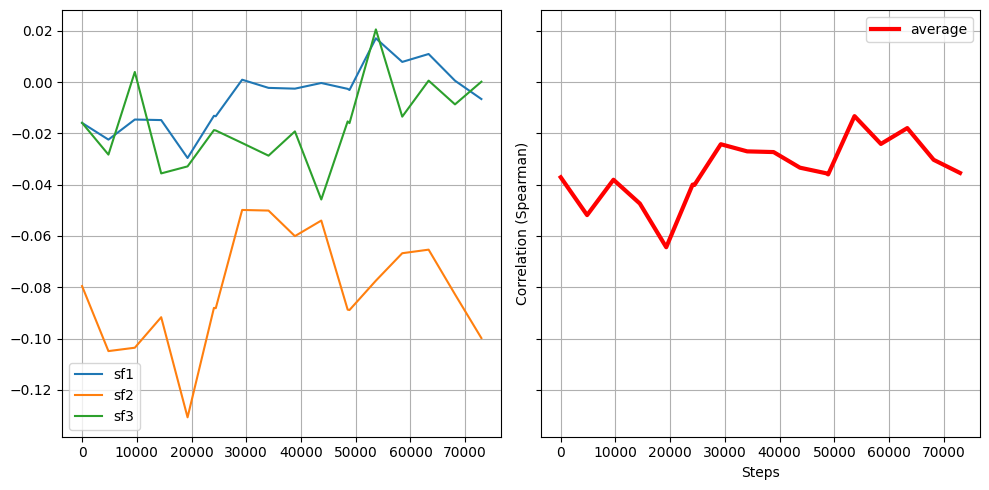

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex = True, sharey = True)

ax1.grid(axis='both')
ax1.plot(array_step, [score[0] for score in array_scores], label = "sf1")
ax1.plot(array_step, [score[1] for score in array_scores], label = "sf2")
ax1.plot(array_step, [score[2] for score in array_scores], label = "sf3")
ax1.legend()

ax2.grid(axis='both')
ax2.plot(array_step, [score[3] for score in array_scores], color = "red", label = "average", lw = 3.0)
ax2.legend()

plt.xlabel("Steps")
plt.ylabel("Correlation (Spearman)")
fig.tight_layout()
fig.show()

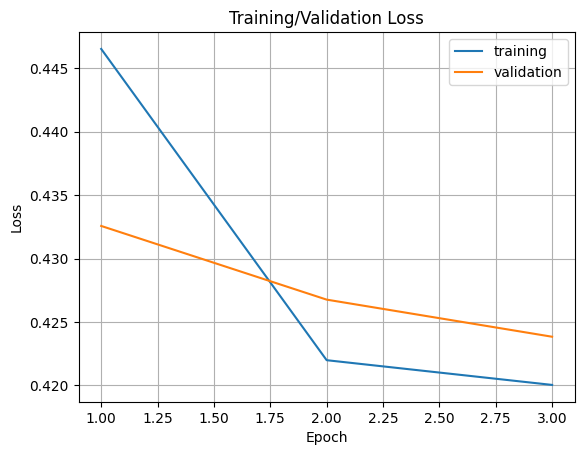

In [ ]:
plt.plot(range(1, epochs+1), array_loss, label = "training")
plt.plot(range(1, epochs+1), array_val, label = "validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training/Validation Loss")
plt.grid(axis='both')
plt.show()

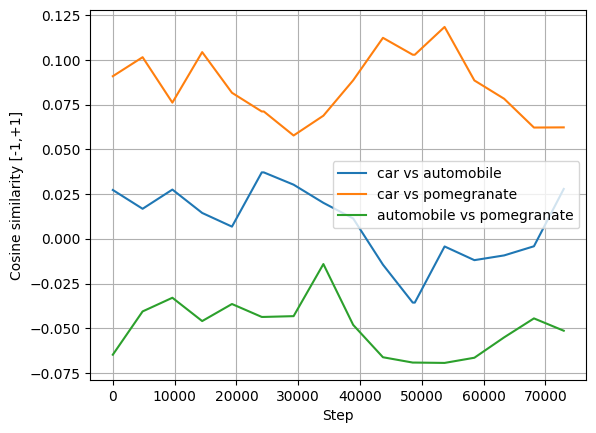

In [ ]:
plt.plot(array_step, [item[0] for item in testwords_similarities], label = ("%s vs %s" % (testwords[0], testwords[1])))
plt.plot(array_step, [item[1] for item in testwords_similarities], label = ("%s vs %s" % (testwords[0], testwords[2])))
plt.plot(array_step, [item[2] for item in testwords_similarities], label = ("%s vs %s" % (testwords[1], testwords[2])))

plt.xlabel("Step")
plt.ylabel("Cosine similarity [-1,+1]")
plt.legend()
plt.grid(axis='both')
plt.show()

# What if we combine target and context embeddings?

In [ ]:
trg_embeddings = model.input_embeddings()
s1, s2, s3, av = get_scores(trg_embeddings)

print("Target embeddings: [SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

Target embeddings: [SP1: -0.007] [SP2: -0.100] [SP3: 0.000] [AVG: -0.036]


In [ ]:
ctx_embeddings = model.output_embeddings()
s1, s2, s3, av = get_scores(ctx_embeddings)

print("Context embeddings: [SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

Context embeddings: [SP1: 0.020] [SP2: 0.036] [SP3: -0.030] [AVG: 0.009]


In [ ]:
combined_embeddings = (trg_embeddings + ctx_embeddings) / 2.0
s1, s2, s3, av = get_scores(combined_embeddings)

print("Combined embeddings: [SP1: %.3f] [SP2: %.3f] [SP3: %.3f] [AVG: %.3f]" % (s1, s2, s3, av))

Combined embeddings: [SP1: 0.015] [SP2: -0.052] [SP3: 0.016] [AVG: -0.007]


# Closest neighbors

In [ ]:
test_words = ["car", "money", "flower", "japan", "suspicious"]

table = PrettyTable()
for w in test_words:
  table.add_column("'%s'" % (w) , model.neighbors_from_word(w))

print(table)

+------------+-------------+-----------+--------------+--------------+
|   'car'    |   'money'   |  'flower' |   'japan'    | 'suspicious' |
+------------+-------------+-----------+--------------+--------------+
|   might    |     usha    |   obispo  |  exempting   |    konoe     |
|   crowd    | microstates |    yale   | intermontane |     pill     |
| remarkable |    picked   |  skeptics |  bonaparte   |   observes   |
|   jjigae   |  barrymore  | nationale |  lippincott  |  suspicious  |
|  yusupov   |    tatsam   |    lcd    |  solitaire   |    cyrene    |
|     kz     |   fulltext  |   gting   |    japan     |  quichotte   |
|    car     |     rods    |  fujitsu  |  philatelic  |  womanizer   |
|  susanna   |    money    |  agreeing |  hispaniola  |   purines    |
|  cauldron  |  pragmatics |   flower  |     bidi     |   knesset    |
|   maoism   |  underside  |    pott   | prolegomena  | conservatism |
+------------+-------------+-----------+--------------+--------------+


# Disconnect from runtime

In [ ]:
from google.colab import runtime
runtime.unassign()